In [1]:
import random
from collections import deque
from copy import deepcopy

import gym
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

In [2]:
SEED = 1
BATCH_SIZE = 32
LR = 0.00025
UP_COEF = 0.1
GAMMA = 0.99
V_MAX = 10
V_MIN = -10
N_ATOMS = 51
DELTA_Z = (V_MAX - V_MIN) / (N_ATOMS - 1)

# set device
use_cuda = torch.cuda.is_available()
device = torch.device('cuda' if use_cuda else 'cpu')

# random seed
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if use_cuda:
    torch.cuda.manual_seed_all(SEED)

In [3]:
class CategoricalDQN(nn.Module):
    def __init__(self, obs_space, action_space, n_atoms):
        super().__init__()

        self.head = nn.Sequential(
            nn.Linear(obs_space, 256),
            nn.SELU(),
            nn.Linear(256, 256),
            nn.SELU()
        )

        self.fc = nn.Sequential(
            nn.Linear(256, 256),
            nn.SELU(),
            nn.Linear(256, action_space * n_atoms)
        )

        self.log_softmax = nn.LogSoftmax(dim=-1)

        self.register_buffer(
            'support', torch.arange(V_MIN, V_MAX + DELTA_Z, DELTA_Z))

    def forward(self, x):
        out = self.head(x)
        out = self.fc(out).reshape(out.shape[0], -1, N_ATOMS)
        log_p = self.log_softmax(out)

        return log_p

In [4]:
losses = []


def learn(net, tgt_net, optimizer, rep_memory):
    net.train()
    tgt_net.train()
    
    train_memory = random.sample(rep_memory, BATCH_SIZE)

    dataloader = DataLoader(train_memory,
                            batch_size=BATCH_SIZE,
                            pin_memory=use_cuda)

    for i, (s, a, r, _s, d) in enumerate(dataloader):
        s_batch = s.to(device).float()
        a_batch = a.to(device).long()
        _s_batch = _s.to(device).float()
        r_batch = r.to(device).float()
        done_mask = 1 - d.to(device).float()
        
        _log_p_batch = net(_s_batch)
        _weights = _log_p_batch.exp() * net.support
        _q_batch = _weights.sum(dim=2)
        _a_batch = torch.argmax(_q_batch, dim=1)

        with torch.no_grad():
            _log_p_batch_tgt = tgt_net(_s_batch)
            _log_p_acting = _log_p_batch_tgt[range(BATCH_SIZE), _a_batch]
            _p_acting = _log_p_acting.exp()
            
        _p_proj = projection(_p_acting, r_batch, done_mask)

        log_p_batch = net(s_batch)
        log_p_acting = log_p_batch[range(BATCH_SIZE), a_batch.data]

        # loss
        loss = -(_p_proj * log_p_acting).sum(dim=1).mean()
        losses.append(loss)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()


def projection(_p_acting, r_batch, done_mask):
    _p_proj = np.zeros((BATCH_SIZE, N_ATOMS), dtype=np.float32)
    r_batch_np = r_batch.cpu().numpy()
    done_mask_np = done_mask.cpu().numpy()
    _p_acting_np = _p_acting.detach().cpu().numpy()
    batch_id = range(BATCH_SIZE)
    for i in range(N_ATOMS):
        z = np.clip(r_batch_np + GAMMA * done_mask_np * (V_MIN + i * DELTA_Z),
                    V_MIN, V_MAX)
        b = (z - V_MIN) / DELTA_Z
        l = np.floor(b).astype(np.int64)
        u = np.ceil(b).astype(np.int64)
        _p_proj[batch_id, l[batch_id]] += _p_acting_np[batch_id, i] * (u - b)[batch_id]
        _p_proj[batch_id, u[batch_id]] += _p_acting_np[batch_id, i] * (b - l)[batch_id]
    
    return torch.tensor(_p_proj).to(device).float()


def select_action(obs, tgt_net):
    tgt_net.eval()
    with torch.no_grad():
        state = torch.tensor([obs]).to(device).float()
        log_p = target_net(state)
        weights = log_p.exp() * net.support
        q = weights.sum(dim=2)
        action = torch.argmax(q, dim=1)

    return action.item()

## Main

In [5]:
# make an environment
# env = gym.make('CartPole-v0')
env = gym.make('CartPole-v1')
# env = gym.make('MountainCar-v0')
# env = gym.make('LunarLander-v2')

env.seed(SEED)
obs_space = env.observation_space.shape[0]
action_space = env.action_space.n

# hyperparameter
n_episodes = 1000
learn_start = 1600
memory_size = 50000
update_frq = 1
use_eps_decay = True
epsilon = 1.0
eps_min = 0.01
decay_rate = 0.0001
n_eval = env.spec.trials

# global values
total_steps = 0
learn_steps = 0
rewards = []
reward_eval = deque(maxlen=n_eval)
is_learned = False
is_solved = False

# make a memory
rep_memory = deque(maxlen=memory_size)

# make two nerual networks
net = CategoricalDQN(obs_space, action_space, N_ATOMS).to(device)
target_net = deepcopy(net)

# make a optimizer
optimizer = optim.Adam(net.parameters(), lr=LR, eps=0.01/BATCH_SIZE)

In [6]:
env.spec.max_episode_steps

500

In [7]:
env.spec.trials

100

In [8]:
env.spec.reward_threshold

475.0

In [9]:
# play
for i in range(1, n_episodes + 1):
    obs = env.reset()
    done = False
    ep_reward = 0
    while not done:
#         env.render()
        if np.random.rand() < epsilon:
            action = env.action_space.sample()
        else:
            action = select_action(obs, target_net)

        _obs, reward, done, _ = env.step(action)

        rep_memory.append((obs, action, reward, _obs, done))

        obs = _obs
        total_steps += 1
        ep_reward += reward

        if use_eps_decay:
            epsilon -= epsilon * decay_rate
            epsilon = max(eps_min, epsilon)

        if len(rep_memory) >= learn_start:
            if len(rep_memory) == learn_start:
                print('\n============  Start Learning  ============\n')
            learn(net, target_net, optimizer, rep_memory)
            learn_steps += 1

        if learn_steps == update_frq:
            # target smoothing update
            for t, n in zip(target_net.parameters(), net.parameters()):
                t.data = UP_COEF * n.data + (1 - UP_COEF) * t.data
            learn_steps = 0

    if done:
        rewards.append(ep_reward)
        reward_eval.append(ep_reward)
        print('{:3} Episode in {:5} steps, reward {:.2f}'.format(
            i, total_steps, ep_reward))

        if len(reward_eval) >= n_eval:
            if np.mean(reward_eval) >= env.spec.reward_threshold:
                print('\n{} is sloved! {:3} Episode in {:3} steps'.format(
                    env.spec.id, i, total_steps))
                torch.save(target_net.state_dict(),
                           f'./test/saved_models/{env.spec.id}_ep{i}_clear_model_cdqn.pt')
                break
env.close()

  1 Episode in    12 steps, reward 12.00
  2 Episode in    27 steps, reward 15.00
  3 Episode in    47 steps, reward 20.00
  4 Episode in    66 steps, reward 19.00
  5 Episode in    76 steps, reward 10.00
  6 Episode in    97 steps, reward 21.00
  7 Episode in   129 steps, reward 32.00
  8 Episode in   182 steps, reward 53.00
  9 Episode in   199 steps, reward 17.00
 10 Episode in   218 steps, reward 19.00
 11 Episode in   274 steps, reward 56.00
 12 Episode in   305 steps, reward 31.00
 13 Episode in   321 steps, reward 16.00
 14 Episode in   330 steps, reward 9.00
 15 Episode in   348 steps, reward 18.00
 16 Episode in   376 steps, reward 28.00
 17 Episode in   392 steps, reward 16.00
 18 Episode in   409 steps, reward 17.00
 19 Episode in   427 steps, reward 18.00
 20 Episode in   474 steps, reward 47.00
 21 Episode in   510 steps, reward 36.00
 22 Episode in   549 steps, reward 39.00
 23 Episode in   570 steps, reward 21.00
 24 Episode in   595 steps, reward 25.00
 25 Episode in   

199 Episode in 18232 steps, reward 205.00
200 Episode in 18530 steps, reward 298.00
201 Episode in 18788 steps, reward 258.00
202 Episode in 19009 steps, reward 221.00
203 Episode in 19238 steps, reward 229.00
204 Episode in 19460 steps, reward 222.00
205 Episode in 19678 steps, reward 218.00
206 Episode in 19876 steps, reward 198.00
207 Episode in 20109 steps, reward 233.00
208 Episode in 20401 steps, reward 292.00
209 Episode in 20684 steps, reward 283.00
210 Episode in 21084 steps, reward 400.00
211 Episode in 21343 steps, reward 259.00
212 Episode in 21550 steps, reward 207.00
213 Episode in 21796 steps, reward 246.00
214 Episode in 22008 steps, reward 212.00
215 Episode in 22290 steps, reward 282.00
216 Episode in 22526 steps, reward 236.00
217 Episode in 22736 steps, reward 210.00
218 Episode in 23030 steps, reward 294.00
219 Episode in 23268 steps, reward 238.00
220 Episode in 23643 steps, reward 375.00
221 Episode in 23876 steps, reward 233.00
222 Episode in 24099 steps, reward

395 Episode in 70018 steps, reward 160.00
396 Episode in 70518 steps, reward 500.00
397 Episode in 70737 steps, reward 219.00
398 Episode in 71237 steps, reward 500.00
399 Episode in 71715 steps, reward 478.00
400 Episode in 71876 steps, reward 161.00
401 Episode in 72072 steps, reward 196.00
402 Episode in 72253 steps, reward 181.00
403 Episode in 72446 steps, reward 193.00
404 Episode in 72732 steps, reward 286.00
405 Episode in 73156 steps, reward 424.00
406 Episode in 73338 steps, reward 182.00
407 Episode in 73472 steps, reward 134.00
408 Episode in 73530 steps, reward 58.00
409 Episode in 73633 steps, reward 103.00
410 Episode in 73756 steps, reward 123.00
411 Episode in 73930 steps, reward 174.00
412 Episode in 74074 steps, reward 144.00
413 Episode in 74201 steps, reward 127.00
414 Episode in 74317 steps, reward 116.00
415 Episode in 74479 steps, reward 162.00
416 Episode in 74645 steps, reward 166.00
417 Episode in 74795 steps, reward 150.00
418 Episode in 74952 steps, reward 

590 Episode in 105815 steps, reward 168.00
591 Episode in 105977 steps, reward 162.00
592 Episode in 106145 steps, reward 168.00
593 Episode in 106320 steps, reward 175.00
594 Episode in 106611 steps, reward 291.00
595 Episode in 106828 steps, reward 217.00
596 Episode in 106998 steps, reward 170.00
597 Episode in 107308 steps, reward 310.00
598 Episode in 107468 steps, reward 160.00
599 Episode in 107612 steps, reward 144.00
600 Episode in 107854 steps, reward 242.00
601 Episode in 108109 steps, reward 255.00
602 Episode in 108285 steps, reward 176.00
603 Episode in 108560 steps, reward 275.00
604 Episode in 108774 steps, reward 214.00
605 Episode in 108938 steps, reward 164.00
606 Episode in 109099 steps, reward 161.00
607 Episode in 109280 steps, reward 181.00
608 Episode in 109456 steps, reward 176.00
609 Episode in 109588 steps, reward 132.00
610 Episode in 109714 steps, reward 126.00
611 Episode in 109836 steps, reward 122.00
612 Episode in 109959 steps, reward 123.00
613 Episode

781 Episode in 135099 steps, reward 148.00
782 Episode in 135255 steps, reward 156.00
783 Episode in 135417 steps, reward 162.00
784 Episode in 135535 steps, reward 118.00
785 Episode in 135667 steps, reward 132.00
786 Episode in 135787 steps, reward 120.00
787 Episode in 136017 steps, reward 230.00
788 Episode in 136125 steps, reward 108.00
789 Episode in 136477 steps, reward 352.00
790 Episode in 136809 steps, reward 332.00
791 Episode in 136981 steps, reward 172.00
792 Episode in 137319 steps, reward 338.00
793 Episode in 137519 steps, reward 200.00
794 Episode in 137721 steps, reward 202.00
795 Episode in 137892 steps, reward 171.00
796 Episode in 138105 steps, reward 213.00
797 Episode in 138456 steps, reward 351.00
798 Episode in 138568 steps, reward 112.00
799 Episode in 138676 steps, reward 108.00
800 Episode in 138797 steps, reward 121.00
801 Episode in 138903 steps, reward 106.00
802 Episode in 139019 steps, reward 116.00
803 Episode in 139145 steps, reward 126.00
804 Episode

973 Episode in 160098 steps, reward 121.00
974 Episode in 160229 steps, reward 131.00
975 Episode in 160355 steps, reward 126.00
976 Episode in 160484 steps, reward 129.00
977 Episode in 160614 steps, reward 130.00
978 Episode in 160737 steps, reward 123.00
979 Episode in 160855 steps, reward 118.00
980 Episode in 160971 steps, reward 116.00
981 Episode in 161094 steps, reward 123.00
982 Episode in 161221 steps, reward 127.00
983 Episode in 161351 steps, reward 130.00
984 Episode in 161487 steps, reward 136.00
985 Episode in 161623 steps, reward 136.00
986 Episode in 161757 steps, reward 134.00
987 Episode in 161878 steps, reward 121.00
988 Episode in 162016 steps, reward 138.00
989 Episode in 162156 steps, reward 140.00
990 Episode in 162282 steps, reward 126.00
991 Episode in 162405 steps, reward 123.00
992 Episode in 162533 steps, reward 128.00
993 Episode in 162658 steps, reward 125.00
994 Episode in 162785 steps, reward 127.00
995 Episode in 162920 steps, reward 135.00
996 Episode

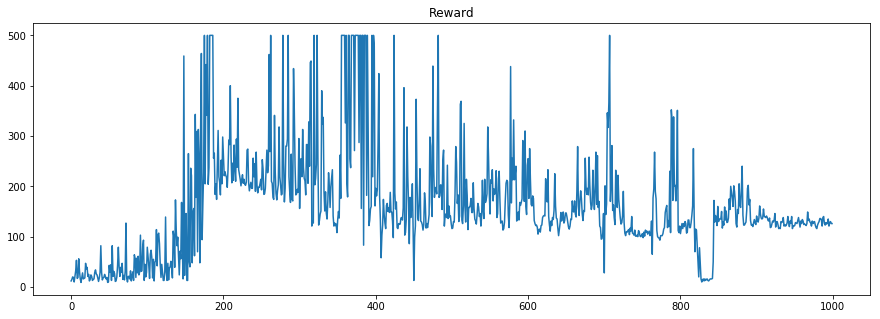

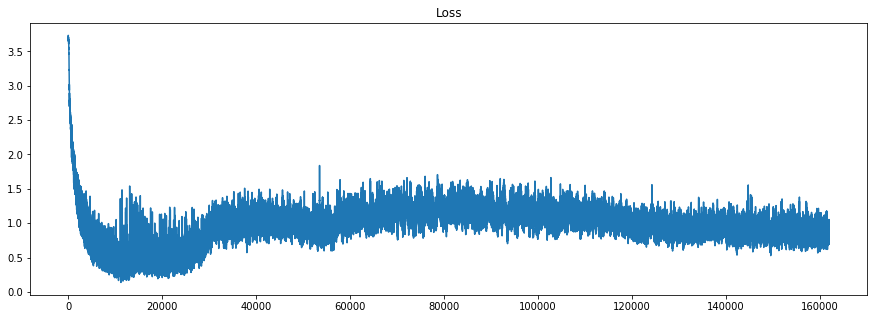

In [10]:
plt.figure(figsize=(15, 5))
plt.title('Reward')
plt.plot(rewards)
plt.figure(figsize=(15, 5))
plt.title('Loss')
plt.plot(losses)
plt.show()

In [11]:
[
    ('CartPole-v0', 215, 0.25),
    ('CartPole-v1', 291, 0.1),
    ('MountainCar-v0', None, 0.1),
    ('LunarLander-v2', None, 0.1)
]

[('CartPole-v0', 215, 0.25),
 ('CartPole-v1', 291, 0.1),
 ('MountainCar-v0', None, 0.1),
 ('LunarLander-v2', None, 0.1)]